Tim Zhao, PHYS 1600 Computational Physics HW3

In [22]:
%matplotlib inline
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

1. Simulate a random walk in three dimensions allowing the walker to make steps of unit length in random directions; don’t restrict the walker to sites on a discrete lattice i.e let the angle defining the step direction vary continuously between $[−\pi/2, \pi/2]$. Show that the motion is diffusive, i.e. $\langle r^2 \rangle \propto t$. Find the value of the proportionality constant.

In [23]:
nsteps=500

phi=np.random.uniform(-np.pi,np.pi,size=(nsteps))
theta=np.random.uniform(-np.pi/2,np.pi/2,size=(nsteps))

x=np.cos(theta)*np.sin(phi)
x=np.insert(x,0,0)

y=np.sin(theta)*np.sin(phi)
y=np.insert(y,0,0)

z=np.cos(phi)
z=np.insert(z,0,0)

path=np.stack((x,y,z), axis=1).cumsum(0)
start = path[:1]
stop = path[-1:]

fig = plt.figure(figsize=(10,10),dpi=1000)
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(path[:,0], path[:,1], path[:,2], c='blue', alpha=0.25,s=1)
ax.plot3D(path[:,0], path[:,1], path[:,2], c='blue', alpha=0.5, lw=0.5)
ax.scatter3D(start[:,0], start[:,1], start[:,2], c='red', marker='+',label='start')
ax.scatter3D(stop[:,0], stop[:,1], stop[:,2], c='black', marker='o',label='stop')
ax.grid(True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Random Walk')
plt.legend()
plt.show()

In [24]:
def randwalk_3D(nsteps = 10, nsamples=10):
    nsteps = int(nsteps)
    nsamples = int(nsamples)

    phi=np.random.uniform(-np.pi,np.pi,size=(nsamples,nsteps))
    theta=np.random.uniform(-np.pi/2,np.pi/2,size=(nsamples,nsteps))

    x=np.cos(theta)*np.sin(phi)
    x=np.insert(x,0,0,axis=1)

    y=np.sin(theta)*np.sin(phi)
    y=np.insert(y,0,0,axis=1)

    z=np.cos(phi)
    z=np.insert(z,0,0,axis=1)
    
    x_traj = np.cumsum(x, axis=1)
    y_traj = np.cumsum(y, axis=1)
    z_traj = np.cumsum(z, axis=1)

    r=np.sqrt(x_traj**2+y_traj**2+z_traj**2)
    rms = np.mean(r**2, axis = 0)
    
    return rms

proportionality constant = 0.988730609960169


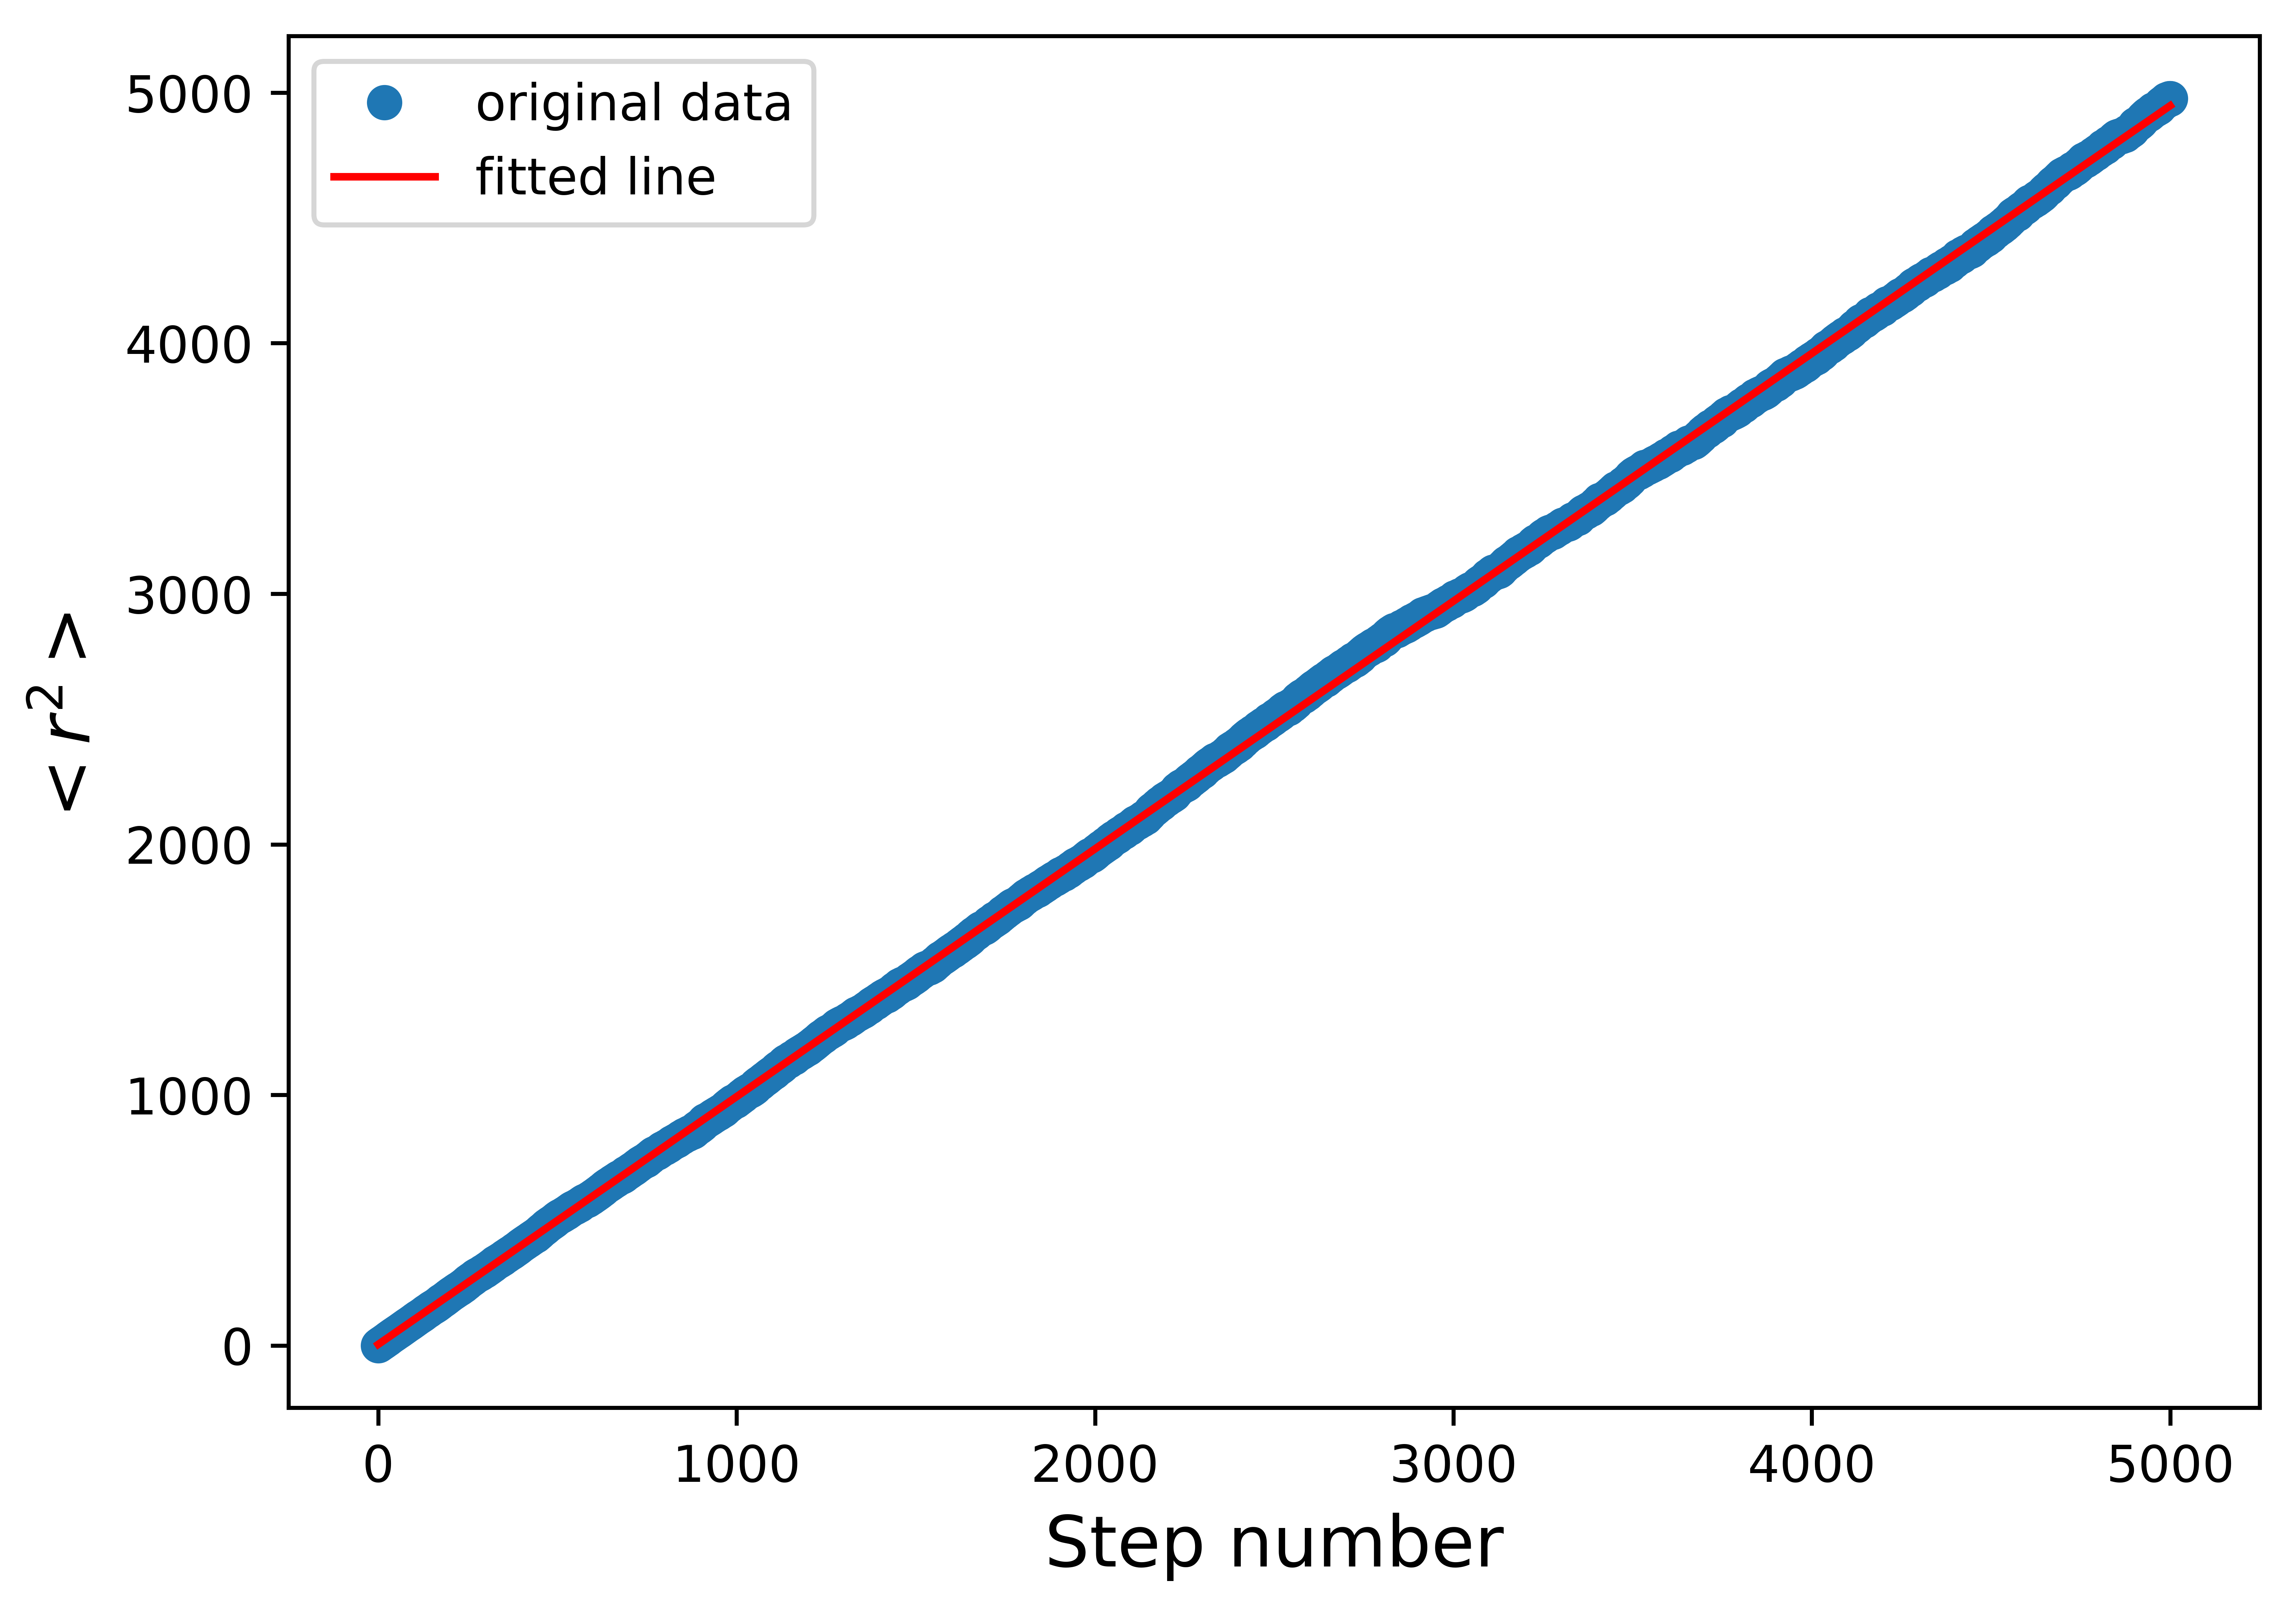

In [25]:
nsteps =5000
nsamples = 5000
rms = randwalk_3D(nsteps, nsamples)
res = linregress(np.arange(nsteps+1), rms)
print('proportionality constant = {}'.format(res.slope))

fig = plt.figure(figsize=(7,5),dpi=1000)
plt.plot(np.arange(nsteps+1), rms, 'o', label='original data')
plt.plot(np.arange(nsteps+1), res.intercept + res.slope*np.arange(nsteps+1), 'r', label='fitted line')
plt.xlabel('Step number', fontsize =14)
plt.ylabel('$<r^2>$', fontsize = 14)
plt.legend()
plt.show()

I used spherical coordinate drawing $-\pi \le \phi \le \pi$ and $-\pi/2 \le \theta \le \pi/2$ uniformly to make continous 3D walk. The proportionality constant is 0.9887

2. Simulate an ensemble of random walkers in two dimensions, constrained to a 100 by 100 square lattice, and starting with an initial distribution in which all of the particles are near the center. Let one of the walls of the container have a small hole of 10 units in length along the edge through which particles can leave the container. Once a particle has left the container, it cannot reenter. Calculate the number of particles in the container as a function of time and show that it varies as $exp(−t/\tau)$, where $\tau$ is an effective time constant for the escape time.

In [26]:
@jit(nopython=True)
def step_2d():
    # step for random walk on 2D square lattice
    d = np.random.randint(1,5)
    if d == 1:
        x_s, y_s = 1, 0
    if d == 2:
        x_s, y_s = 0, 1
    if d == 3:
        x_s, y_s = -1, 0
    if d == 4:
        x_s, y_s = 0, -1
    return [x_s, y_s]

@jit(nopython=True)
def randwalk_2d(nsteps, wall = 50, r0=(0,0)):
    # trajectory for a single 2D random walk
    x = np.zeros(nsteps+1, np.double)
    y = np.zeros(nsteps+1, np.double)
    
    #list of indicator variable, 1 = inside, 0 = outside
    box=np.ones(nsteps+1)
    
    # intial position
    x[0]=r0[0]
    y[0]=r0[1]

    for i in range(nsteps):
        #walk
        s = step_2d()
        x[i+1] = x[i] + s[0]
        y[i+1] = y[i] + s[1]
        
        #check if left box, exit at middle of right wall
        if x[i+1] > wall and -5 < y[i+1] < 6:
            x[i+2:]=x[i+1]
            y[i+2:]=y[i+1]
            box[i+1:]=0
            break
        
        #if hit wall, stay at same position
        else:      
            if abs(x[i+1]) > wall:
                x[i+1] = x[i]      
            if abs(y[i+1]) > wall:
                y[i+1] = y[i]
    
    return x, y, box

@jit(nopython=True)
def ensemble_2d(N, t_max, wall = 50, r0=(0,0)):
    #generate an ensemble or random walkers
    box_ensemble=[]
    for i in range(N):
        x, y, box = randwalk_2d(t_max, wall, r0)
        box_ensemble.append(box)

    return box_ensemble

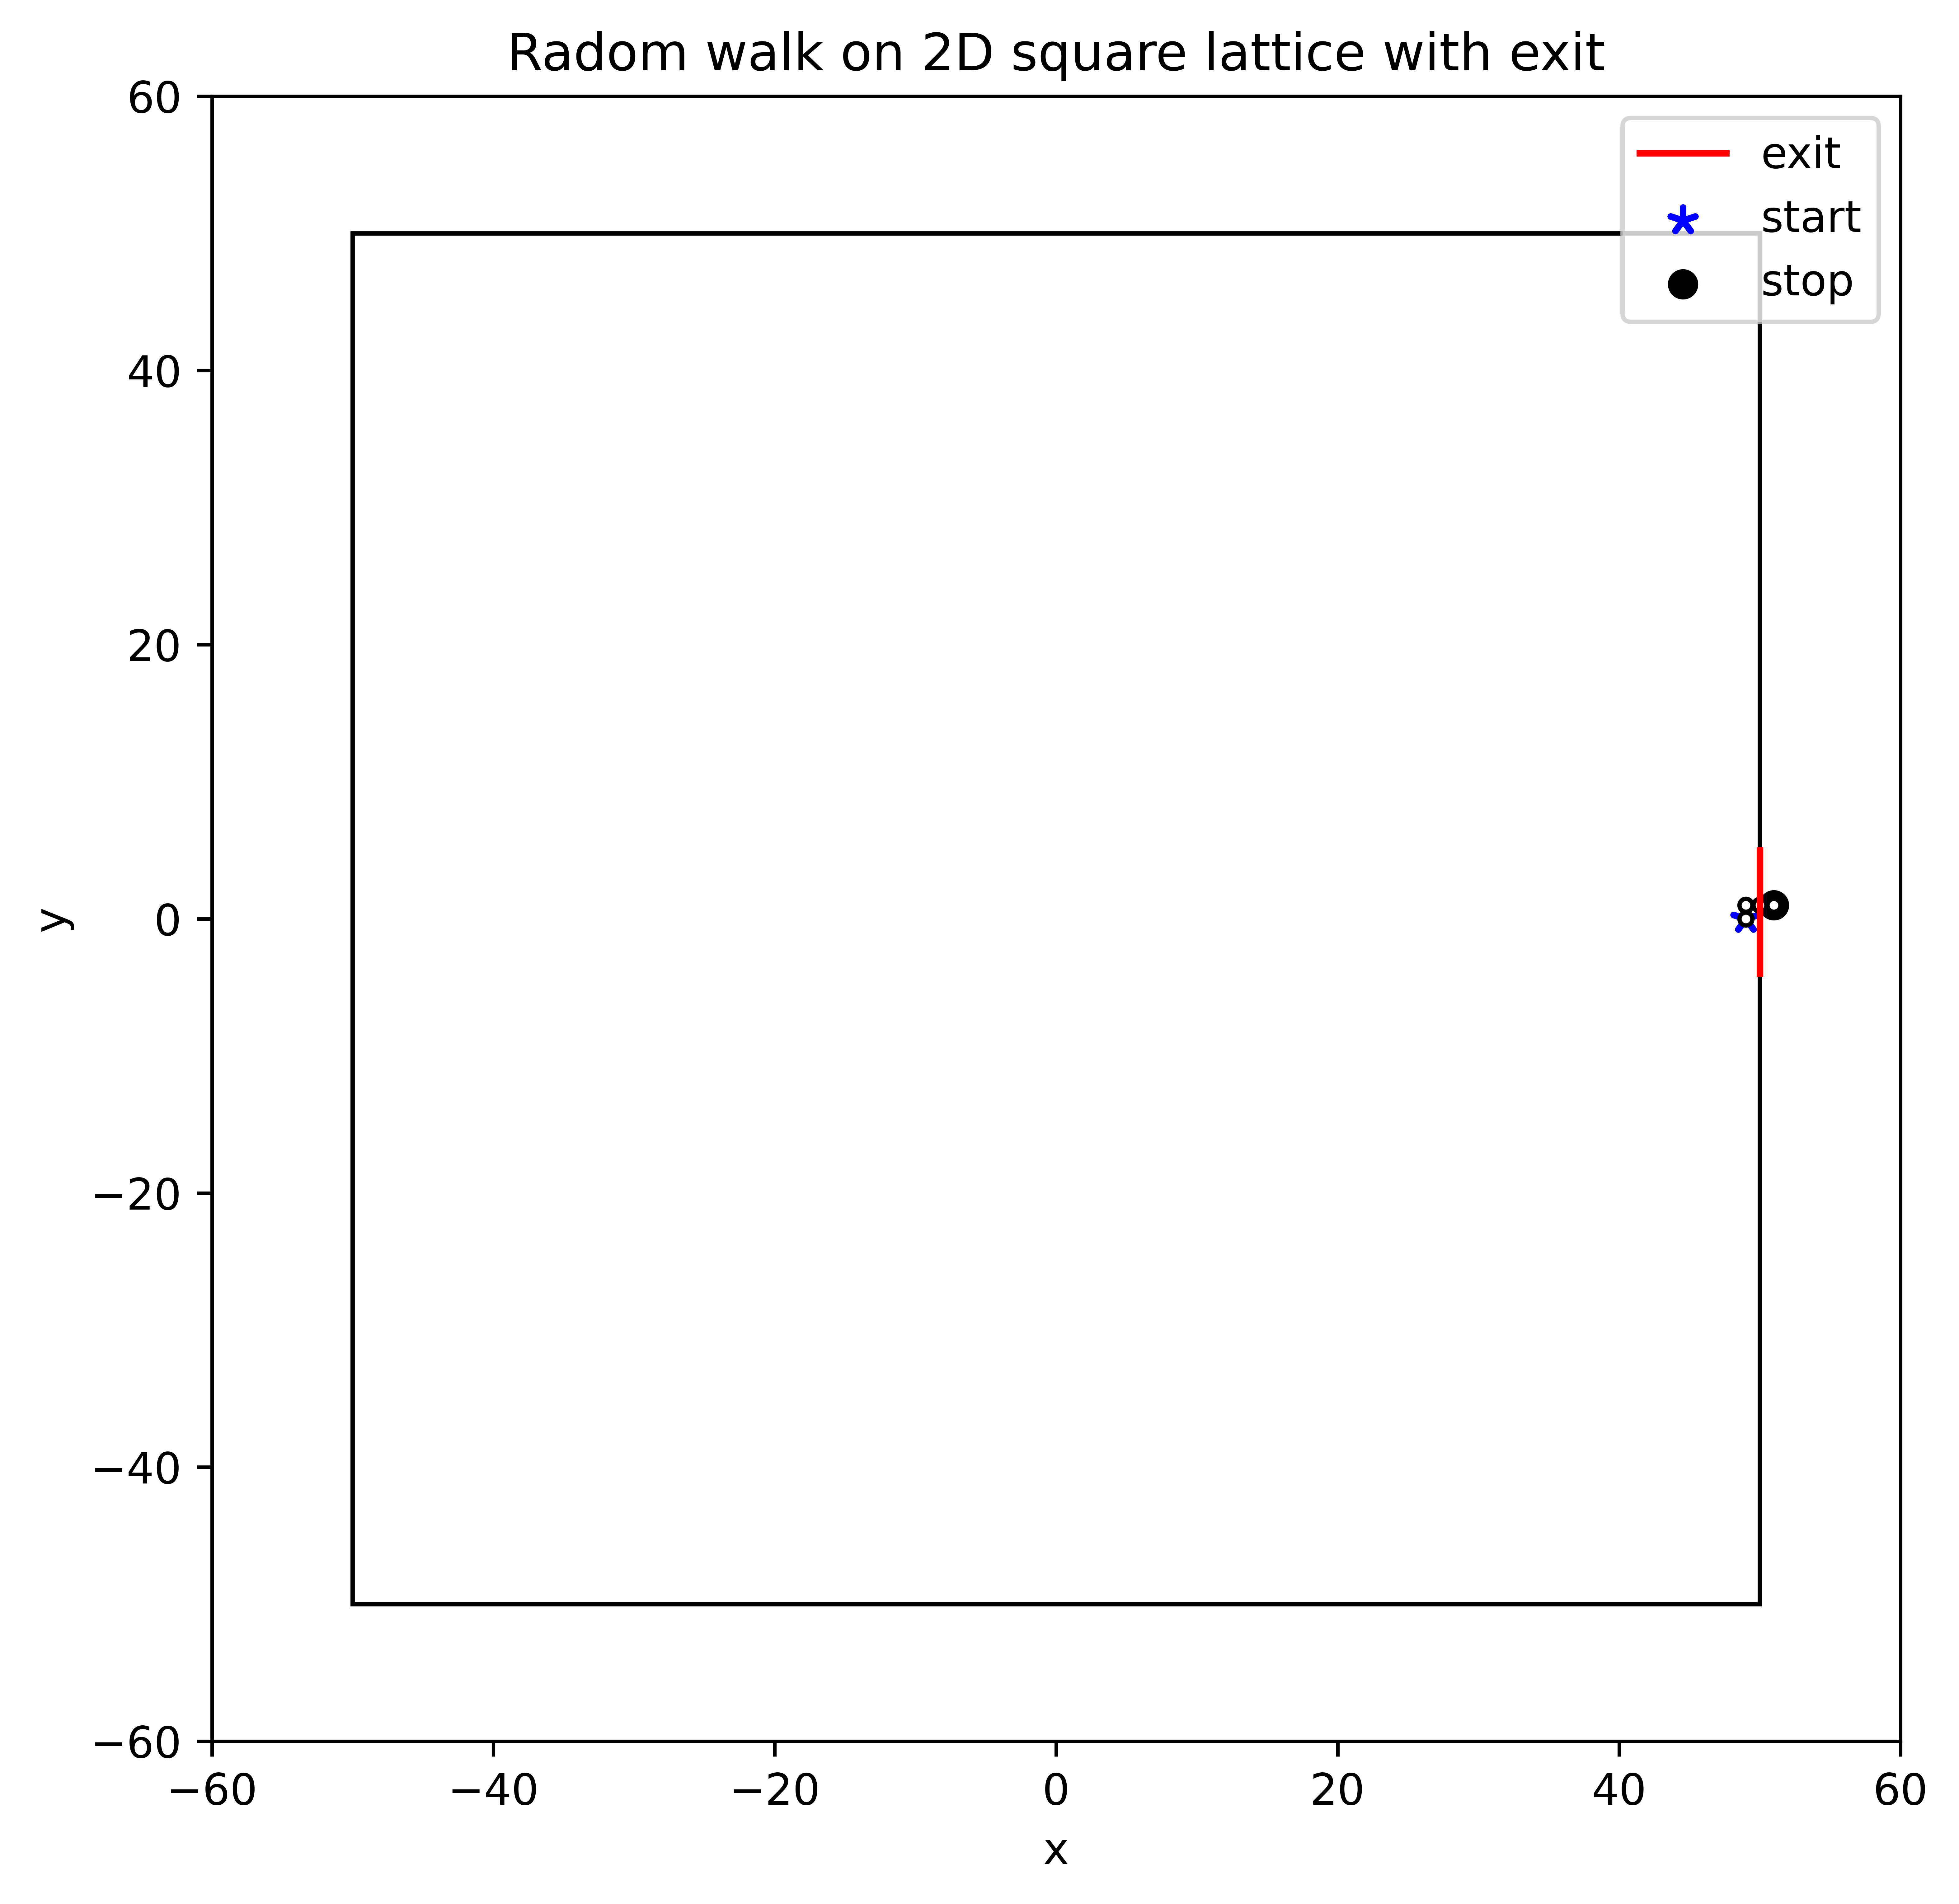

positions
[[49.  0.]
 [49.  1.]
 [50.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]
 [51.  1.]]
list of indicator variable, 1 = inside, 0 = outside
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
n = 10
x,y,box = randwalk_2d(n, wall = 50, r0=(49,0))
fig = plt.figure(figsize=(7,7),dpi=1000)
ax = fig.add_subplot(111)
colormap = cm.Reds
#ax.scatter(x, y, c=np.arange(101), cmap='Reds')
ax.plot(x,y, marker = '.', ls = 'None', mfc = 'w', mec ='k')
ax.quiver(x[:-1],y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], np.arange(n), cmap = 'RdBu', scale = 1, units = 'xy', scale_units = 'xy', width = 0.075, headwidth = 4)
ax.scatter(x[0], y[0], c='blue', marker=(5, 2),label='start')
ax.scatter(x[-1],y[-1], c='black', marker='o',label='stop')
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Radom walk on 2D square lattice with exit')

ax.plot(50*np.ones(10),np.arange(-4,6,1),color='r',label='exit')

rect = patches.Rectangle((-50, -50), 100, 100, linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)

plt.legend()
plt.show()

print('positions')
print(np.stack((x,y),axis=1))

print('list of indicator variable, 1 = inside, 0 = outside')
print(box)

In [37]:
def escape(x,A, tau):
    return (A*np.exp(-x/tau)) + (10000-A)

In [38]:
def ensemble_escape(N,nsteps,wall,r0):
    box=ensemble_2d(N=N, t_max=nsteps, wall=wall, r0=r0)
    box=np.array(box)
    num_particle=np.sum(box,axis=0)
    ts=np.linspace(0,nsteps,nsteps+1)
    popt, pcov = curve_fit(escape, ts, num_particle)
    popt_2=np.append(popt, [10000-popt[0]])
    
    fig = plt.figure(figsize=(7,5),dpi=100)
    plt.scatter(ts,num_particle,label='# particle')
    plt.plot(ts, escape(ts, *popt), 'r-',label='fit = %5.2f * exp(-t/%5.3f) + %5.2f' % tuple(popt_2))
    plt.xlabel('time step')
    plt.ylabel('# particles in the box')
    plt.legend()
    plt.show()
    print('initial position = {}, tau = {}'.format(r0, round(popt[1],2)))

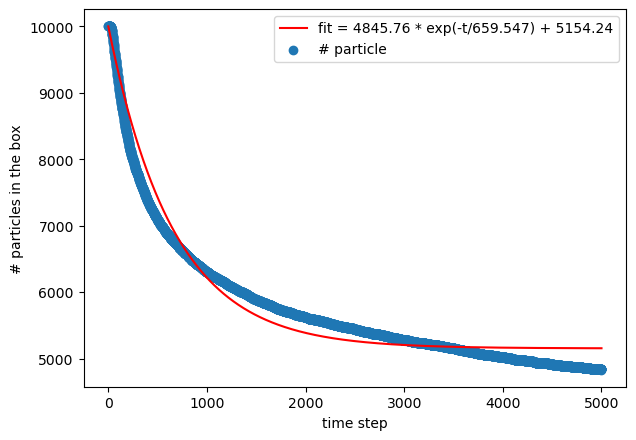

initial position = (40, 0), tau = 659.55


In [39]:
N=10000
nsteps=5000
wall=50
r0=(40,0)

ensemble_escape(N,nsteps,wall,r0)

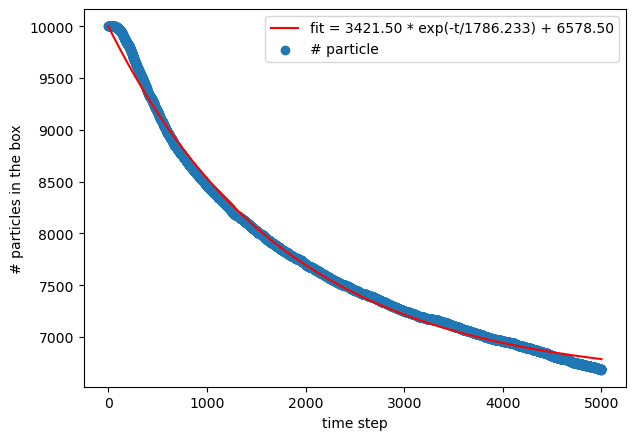

initial position = (30, 0), tau = 1786.23


In [40]:
N=10000
nsteps=5000
wall=50
r0=(30,0)

ensemble_escape(N,nsteps,wall,r0)

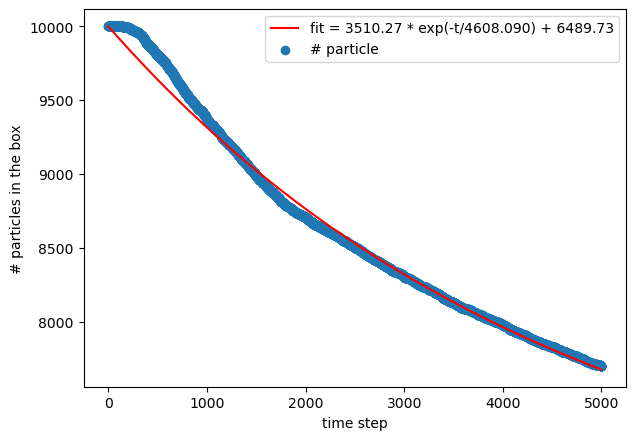

initial position = (20, 0), tau = 4608.09


In [41]:
N=10000
nsteps=5000
wall=50
r0=(20,0)

ensemble_escape(N,nsteps,wall,r0)

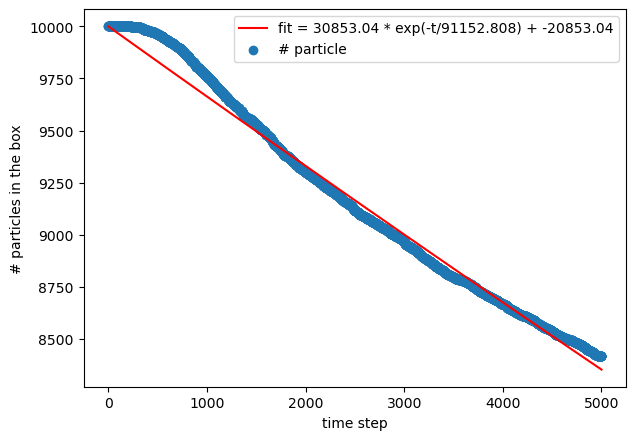

initial position = (10, 0), tau = 91152.81


In [15]:
N=10000
nsteps=5000
wall=50
r0=(10,0)

ensemble_escape(N,nsteps,wall,r0)

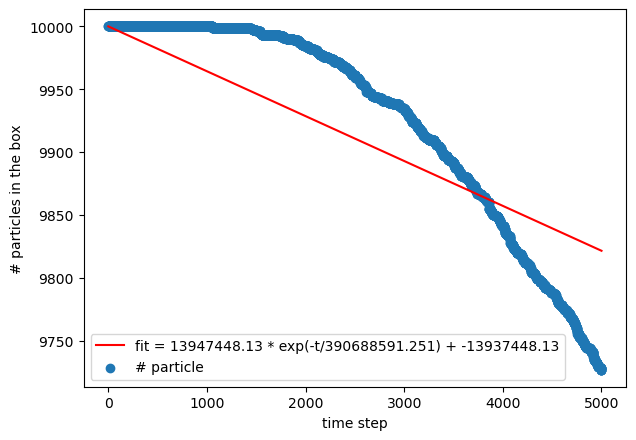

initial position = (-40, 0), tau = 390688591.25


In [42]:
N=10000
nsteps=5000
wall=50
r0=(-40,0)

ensemble_escape(N,nsteps,wall,r0)

For fitting paramters, I enforced the number of particle at $t=0$ as the total number of particles, which resulted in less than ideal fits. In addition, The escape rate, and therefore escape time constant $\tau$, is highly dependent on the starting positions of the ensemble. The number of particles exponentially decays when the ensemble is started near the exit and decreases linearly when started near the center. This makes sense because particles are more likely to exit when they are initially concentrated near the exit. However, as time goes on, the ensemble diffuses throughout out the box, and the exit rate decreases exponentially. When the ensemble os started near the center, the particles exit randoml, and the decrease is linear.

When the ensemble is started far away from the exit, very few particles escape initially because it takes time before any particles can reach the exit. However, as particles diffuses in the box, the escape rate becomes linear, similar to when the ensemble is started at the center.

3. Calculate the value for the integral
$I=\int^1_0 \frac{x^{-1/2}}{e^x+1} dx$ using importance sampling with $w(x) = x^{−1/2}$.

(a) Show that the probability distribution from which sample points should be drawn is given by
$p(x) = \frac{1}{2\sqrt{x}}$ and write a program that draws random values in the range 0 to 1 from this distribution.


\begin{equation}
\begin{split}
p(x)&=\frac{w(x)}{\int^b_aw(x)dx}\\ 
&= \frac{x^{-1/2}}{\int^1_0 x^{-1/2}dx}\\
&=\frac{x^{-1/2}}{2}\\
&=\frac{1}{2\sqrt{x}}
\end{split}
\end{equation}

We want to find $y=G(x)=F^{-1}(x)$, where $F(y)=\int^y_0 p(y)dy$, and x has a uniform random distribution.

\begin{equation}
\begin{split}
F(y)&=\int^y_00.5y^{-1/2}dx\\
&= 0.5*2y^{1/2}\Big|_0^y\\
&=y^{1/2}
\end{split}
\end{equation}

Therefore $x=\sqrt{y}$ and $y=x^2$

In [48]:
N=1000000
x=np.random.random(N)
y=x**2

(b) Using your program from (a), sample $N = 1 × 10^6$ random points and evaluate the integral. You should get a value close to 0.84.

New integrant $g(x)=f(x)/p(x)=\frac{x^{-1/2}}{e^x+1} 2\sqrt{x}= \frac{2}{e^x+1}$

In [50]:
def g(x):
    return 2/(1+np.exp(x))

I = g(y).mean()

print('I = {}'.format(I))

I = 0.8387062471072592
